In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
raw_data_base_path = "/users/amtseng/att_priors/data/raw/"
proc_data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
tfm_results_path = "/users/amtseng/att_priors/results/tfmodisco/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [ ]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(proc_data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
num_strands = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
task_index = None
noprior_model_path = os.path.join(model_base_path, "K562/18/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/9/model_ckpt_epoch_8.pt")

In [5]:
# BPNet
condition_name = "BPNet"
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(proc_data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
if model_type == "profile":
    controls = "shared"
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor

bpnet_tasks = ["Nanog", "Oct4", "Sox2"]
task_index = None
noprior_model_path = os.path.join(model_base_path, "BPNet/22/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/27/model_ckpt_epoch_11.pt")

In [6]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [7]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [8]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We also create a loader for the GC content

In [9]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

### Compute importances

In [ ]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [10]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls,
            task_index=task_index
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, task_index=task_index
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [11]:
# Pick a sample of 1000 random coordinates/bins
num_samples = 1000
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [12]:
# Get coordinates for the sample
if model_type == "profile":
    # For profile models, add a random jitter to avoid center-bias
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [13]:
# Compute the importance scores and 1-hot seqs
imp_type = ("SHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "SHAP scores" else compute_gradients
noprior_scores, _ = imp_func(noprior_model, sample)
prior_scores, one_hot_seqs = imp_func(prior_model, sample)

### Compare importance tracks to GC content

In [18]:
def get_windowed_frac_gc(imp_scores, window_size=10):
    fracs = []
    num_windows_per_track = imp_scores.shape[1] - window_size + 1
    for score_track in tqdm.notebook.tqdm(imp_scores):
        for i in range(num_windows_per_track):
            window = score_track[i : i + window_size]
            frac = np.sum(np.abs(window[:, 1:3])) / np.sum(np.abs(window))
            if np.isnan(frac):
                frac = 0
            fracs.append(frac)
    return np.array(fracs)

In [15]:
window_size = 10

In [19]:
noprior_frac_gc = get_windowed_frac_gc(noprior_scores, window_size=window_size)
prior_frac_gc = get_windowed_frac_gc(prior_scores, window_size=window_size)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Average fraction without priors: 0.506333
Average fraction with priors: 0.507024
One-sided paired t-test p: 0.000000


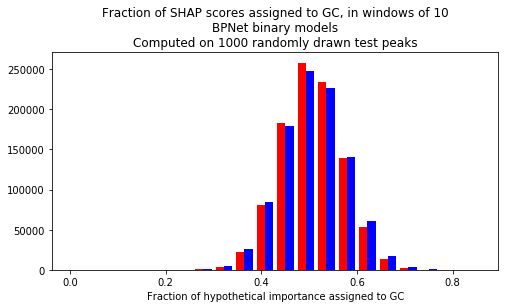

In [20]:
bin_num = 20
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_frac_gc, prior_frac_gc],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    ("Fraction of %s assigned to GC, in windows of %d" % (imp_type, window_size)) +
    ("\n%s %s models" % (condition_name, model_type)) +
    ("\nComputed on %d randomly drawn test peaks" % len(sample))
)
plt.xlabel("Fraction of hypothetical importance assigned to GC")

print("Average fraction without priors: %f" % np.mean(noprior_frac_gc))
print("Average fraction with priors: %f" % np.mean(prior_frac_gc))
t, p = scipy.stats.ttest_rel(noprior_frac_gc, prior_frac_gc)
print("One-sided paired t-test p: %f" % (p / 2))

In [ ]:
# Plot out a few examples
center_slice = slice(400, 600)
for i in np.random.choice(num_samples, size=3, replace=False):
    print(i, sample[i])
    print("=========================")
    print("Without priors:")
    viz_sequence.plot_weights(noprior_scores[i][center_slice] * one_hot_seqs[i][center_slice], subticks_frequency=10)
    print("With priors:")
    viz_sequence.plot_weights(prior_scores[i][center_slice] * one_hot_seqs[i][center_slice], subticks_frequency=10)

In [ ]:
gc_counts = np.sum(one_hot_seqs[:, :, 1:3], axis=(1, 2))

In [ ]:
noprior_frac_gc = np.mean(noprior_scores[:, :, 1:3], axis=(1, 2)) / np.mean(noprior_scores, axis=(1, 2))
prior_frac_gc = np.mean(prior_scores[:, :, 1:3], axis=(1, 2)) / np.mean(prior_scores, axis=(1, 2))

In [ ]:
prior_frac_gc

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].scatter(np.sum(np.abs(noprior_scores), axis=(1, 2)), gc_counts)
ax[1].scatter(np.sum(np.abs(prior_scores), axis=(1, 2)), gc_counts)